<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Aplicaciones Recientes de Redes Neuronales </H3>
<hr style="height:2px;border:none"/>

<H3 align='center'> Fernanda Urrea, ROL: 201551522-0</H3>
<H3 align='center'>Matías Gómez, ROL: 201460501-3</H3>

## 4. Distintos tipos de autoencoders (AEs) en MNIST

### Como se ha discutido en clases, las RBM’s y posteriormente los AE's (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. Recientemente se ha propuesto AE's con distribuciones de probabilidades en su codificación, VAE [[7]](#refs). Los VAE son una variación bayesiana que aprende los parámetros de alguna distribución de probabilidad de variables latentes definida sobre los datos, a través de esa variable latente el decodificador generar/reconstruye nuevos datos $\hat{x}$. En resumidas cuentas, es un autoencoder que aprende un modelo sobre las variables latentes de los datos.

<img src="https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png" title="mnist" width="25%" style="float: right;" />

### Con este objetivo en mente, utilizaremos un dataset simple denominado **MNIST**. Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes



### Cargue los datos desde el repositorio de Keras.

In [58]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
import numpy as np

#matplotlib.use('agg')

import keras
import keras.backend as K
from keras.datasets import mnist


In [143]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,:,:,None] #add channels
x_test = x_test[:,:,:,None]
img_rows, img_cols,channel = x_train.shape[1:]
original_img_size = (img_rows, img_cols,channel) # input image dimensions

In [14]:
len(x_train)

60000

In [15]:
len(x_train[0])

28

In [18]:
len(x_train[0][0])

28

In [19]:
len(x_train[0][0][0])

1

In [82]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

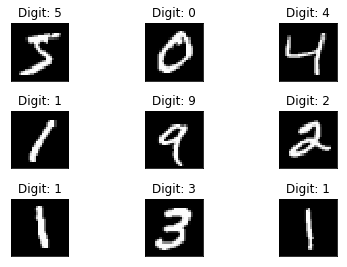

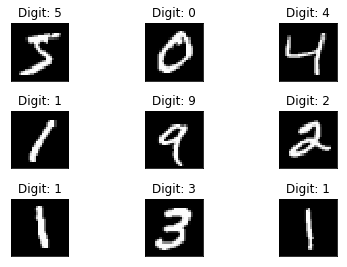

In [39]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
fig

### a) Normalice las imágenes de modo que los pixeles queden en el rango [0, 1] como se acostumbra al trabajar con imágenes. Visualice y comente sobre los datos a trabajar.

In [68]:
x_train = x_train.astype('float32') / 255. 
x_test =  x_test.astype('float32') / 255.

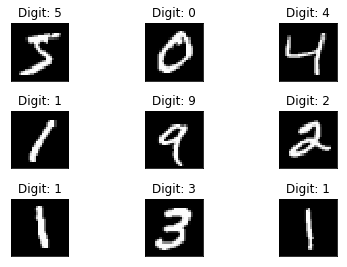

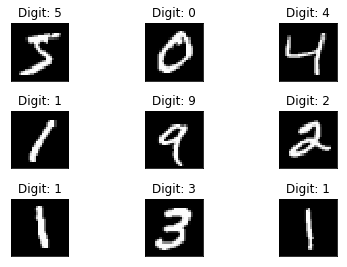

In [41]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
fig

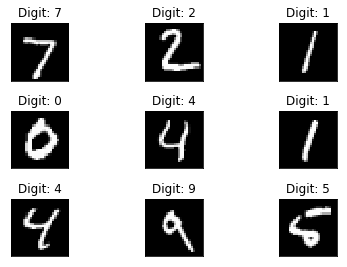

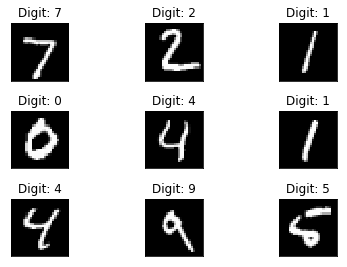

In [42]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(x_test[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_test[i]))
    plt.xticks([])
    plt.yticks([])
fig

Notamos que hay ciertos números que es probable que se confundan con facilidad, aquellos que tienen cierta curvatura por ejemplo el 0. Por otro lado el número 5 es el menos claro de todos pues además le falta un pedazo.

## 4.1 Autoencoder clásico

### Una de las aplicaciones tı́picas de un AE es **reducción de dimensionalidad**, es decir, implementar una transformación $\phi:{\rm I\!R}^d \rightarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento.


<img src="https://miro.medium.com/max/1400/0*yGqTBMopqHbR0fcF." title="AE" width="50%" />


### a) Entrene un AE básico, 1 capa escondida *feed forward*, para generar una representación de MNIST en $d'= 2, 8, 16, 32$ dimensiones. Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. ¿Mejora el resultado si elegimos una función de activación **ReLU** para el Encoder? ¿Podrı́a utilizarse esta activación en el Decoder?

In [158]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [159]:
x_train = x_train.astype('float32') / 255. 
x_test =  x_test.astype('float32') / 255.

In [146]:
x_train = x_train[:,:,:,None] #add channels
x_test = x_test[:,:,:,None]
img_rows, img_cols,channel = x_train.shape[1:]
original_img_size = (img_rows, img_cols,channel) # input image dimensions

#### Para d'=2:####

In [149]:
from keras.layers import Input, Dense, Flatten,Reshape
from keras.models import Model
compres_dim = 2
input_img = Input(shape=original_img_size)
input_fl = Flatten()(input_img) #to get a vector representation
encoded1 = Dense(compres_dim, activation='sigmoid')(input_fl)
decoded1 = Dense(np.prod(original_img_size), activation='sigmoid')(encoded1)
decoded1 = Reshape(original_img_size)(decoded1)
autoencoder1 = Model(inputs=input_img, outputs=decoded1)
encoder1 = Model(inputs=input_img, outputs=encoded1)
autoencoder1.compile(optimizer='rmsprop', loss='binary_crossentropy')
autoencoder1.fit(x_train,x_train,epochs=40,batch_size=32,validation_data=(x_test,x_test))
autoencoder1.save('basic_autoencoder1.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 8s 136us/step - loss: 0.3407 - val_loss: 0.2638
Epoch 2/40
60000/60000 [==============================] - 7s 115us/step - loss: 0.2630 - val_loss: 0.2625
Epoch 3/40
60000/60000 [==============================] - 7s 117us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 4/40
60000/60000 [==============================] - 7s 118us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 5/40
60000/60000 [==============================] - 7s 116us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 6/40
60000/60000 [==============================] - 7s 118us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 7/40
60000/60000 [==============================] - 7s 123us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 8/40
60000/60000 [==============================] - 7s 122us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 9/40
60000/60000 [==============================] - 7s 125us/step - loss: 0.2629 - val_loss: 0.2

#### Para d'=4:####

In [150]:
from keras.layers import Input, Dense, Flatten,Reshape
from keras.models import Model
compres_dim = 8
input_img = Input(shape=original_img_size)
input_fl = Flatten()(input_img) #to get a vector representation
encoded2 = Dense(compres_dim, activation='sigmoid')(input_fl)
decoded2 = Dense(np.prod(original_img_size), activation='sigmoid')(encoded2)
decoded2 = Reshape(original_img_size)(decoded2)
autoencoder2 = Model(inputs=input_img, outputs=decoded2)
encoder2 = Model(inputs=input_img, outputs=encoded2)
autoencoder2.compile(optimizer='rmsprop', loss='binary_crossentropy')
autoencoder2.fit(x_train,x_train,epochs=40,batch_size=32,validation_data=(x_test,x_test))
autoencoder2.save('basic_autoencoder2.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 9s 147us/step - loss: 0.2885 - val_loss: 0.2627
Epoch 2/40
60000/60000 [==============================] - 8s 133us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 3/40
60000/60000 [==============================] - 8s 131us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 4/40
60000/60000 [==============================] - 8s 136us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 5/40
60000/60000 [==============================] - 8s 132us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 6/40
60000/60000 [==============================] - 8s 130us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 7/40
60000/60000 [==============================] - 8s 131us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 8/40
60000/60000 [==============================] - 8s 131us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 9/40
60000/60000 [==============================] - 8s 131us/step - loss: 0.2630 - val_loss: 0.2

#### Para d'=16:####

In [151]:
from keras.layers import Input, Dense, Flatten,Reshape
from keras.models import Model
compres_dim = 16
input_img = Input(shape=original_img_size)
input_fl = Flatten()(input_img) #to get a vector representation
encoded3 = Dense(compres_dim, activation='sigmoid')(input_fl)
decoded3 = Dense(np.prod(original_img_size), activation='sigmoid')(encoded3)
decoded3 = Reshape(original_img_size)(decoded3)
autoencoder3 = Model(inputs=input_img, outputs=decoded3)
encoder3 = Model(inputs=input_img, outputs=encoded3)
autoencoder3.compile(optimizer='rmsprop', loss='binary_crossentropy')
autoencoder3.fit(x_train,x_train,epochs=40,batch_size=32,validation_data=(x_test,x_test))
autoencoder3.save('basic_autoencoder3.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 9s 143us/step - loss: 0.2761 - val_loss: 0.2626
Epoch 2/40
60000/60000 [==============================] - 8s 128us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 3/40
60000/60000 [==============================] - 8s 138us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 4/40
60000/60000 [==============================] - 8s 135us/step - loss: 0.2630 - val_loss: 0.2626
Epoch 5/40
60000/60000 [==============================] - 7s 122us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 6/40
60000/60000 [==============================] - 7s 124us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 7/40
60000/60000 [==============================] - 8s 129us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 8/40
60000/60000 [==============================] - 7s 124us/step - loss: 0.2630 - val_loss: 0.2628
Epoch 9/40
60000/60000 [==============================] - 8s 129us/step - loss: 0.2630 - val_loss: 0.2

#### Para d'=32:####

In [152]:
from keras.layers import Input, Dense, Flatten,Reshape
from keras.models import Model
compres_dim = 32
input_img = Input(shape=original_img_size)
input_fl = Flatten()(input_img) #to get a vector representation
encoded4 = Dense(compres_dim, activation='sigmoid')(input_fl)
decoded4 = Dense(np.prod(original_img_size), activation='sigmoid')(encoded4)
decoded4 = Reshape(original_img_size)(decoded4)
autoencoder4 = Model(inputs=input_img, outputs=decoded4)
encoder4 = Model(inputs=input_img, outputs=encoded4)
autoencoder4.compile(optimizer='rmsprop', loss='binary_crossentropy')
autoencoder4.fit(x_train,x_train,epochs=40,batch_size=32,validation_data=(x_test,x_test))
autoencoder4.save('basic_autoencoder4.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 9s 152us/step - loss: 0.2689 - val_loss: 0.2556
Epoch 2/40
60000/60000 [==============================] - 9s 145us/step - loss: 0.2413 - val_loss: 0.2262
Epoch 3/40
60000/60000 [==============================] - 9s 143us/step - loss: 0.2187 - val_loss: 0.2122
Epoch 4/40
60000/60000 [==============================] - 8s 133us/step - loss: 0.2099 - val_loss: 0.2066
Epoch 5/40
60000/60000 [==============================] - 9s 145us/step - loss: 0.2060 - val_loss: 0.2042
Epoch 6/40
60000/60000 [==============================] - 9s 146us/step - loss: 0.2040 - val_loss: 0.2024
Epoch 7/40
60000/60000 [==============================] - 9s 145us/step - loss: 0.2027 - val_loss: 0.2015
Epoch 8/40
60000/60000 [==============================] - 9s 155us/step - loss: 0.2018 - val_loss: 0.2007
Epoch 9/40
60000/60000 [==============================] - 9s 146us/step - loss: 0.2003 - val_loss: 0.1

Usar Relu en el encoder es posible cuando es una sola capa, es decir no hay riesgo de que explote.

### b) Compare visualmente la reconstrucción que logra hacer el autoencoder desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. Determine si la percepción visual se corresponde con el error de reconstrucción observada. Comente.

In [84]:
#import matplotlib as plt
#plt.rcParams.update({'figure.max_open_warning': 0})

<function matplotlib.pyplot.show(*args, **kw)>

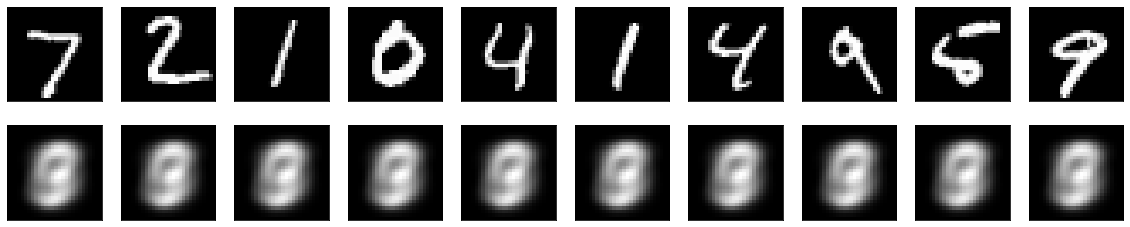

In [155]:
#PARA D=2
from keras.models import load_model
autoencoder = load_model('basic_autoencoder1.h5')
decoded_test = autoencoder1.predict(x_test)
encoded_test = encoder1.predict(x_test)
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

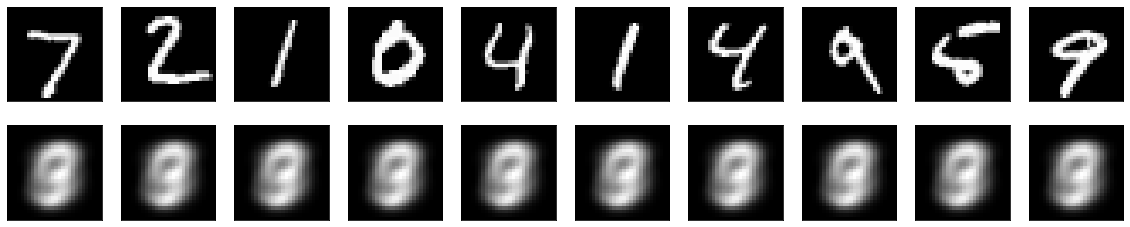

In [156]:
#Para D=8
from keras.models import load_model
autoencoder = load_model('basic_autoencoder2.h5')
decoded_test = autoencoder2.predict(x_test)
encoded_test = encoder2.predict(x_test)
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

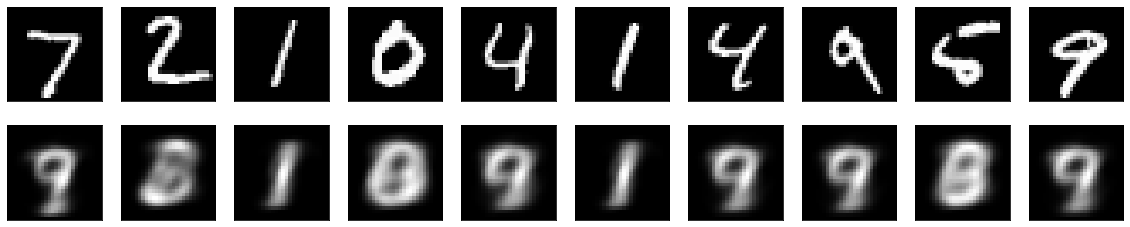

In [154]:
#Para D=16
from keras.models import load_model
autoencoder = load_model('basic_autoencoder3.h5')
decoded_test = autoencoder3.predict(x_test)
encoded_test = encoder3.predict(x_test)
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

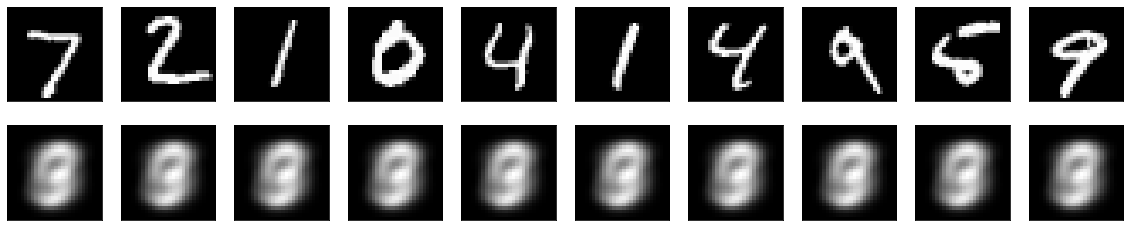

In [148]:
#PARA D=32
from keras.models import load_model
autoencoder = load_model('basic_autoencoder4.h5')
decoded_test = autoencoder4.predict(x_test)
encoded_test = encoder4.predict(x_test)
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show

### c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. Mida el error, en conjunto de entrenamiento y pruebas, obtenido construyendo este clasificador sobre la data reducida a través del autoencoder comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación, además de comparar los tiempos medios de predicción en ambos escenarios. 

In [160]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=compres_dim)
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)
clf = KNeighborsClassifier(10) #CLASIFICATION
clf.fit(pca_train, y_train)
print('Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test))
clf = KNeighborsClassifier(10) #CLASIFICATION
clf.fit(encoded_train, y_train)
print('Classification Accuracy %.2f' % clf.score(encoded_test,y_test))

ValueError: Found array with dim 3. Estimator expected <= 2.

### d) Modifique el autoencoder básico construido en (a) para implementar un *deep autoencoder* (más de dos capas) haciendo uso de las capas convolucionales para trabajar sobre matrices. Comente cómo sufre las transformaciones el patrón de entrada. Demuestre experimentalmente que este autoencoder puede mejorar la compresión obtenida por PCA y por el obtenido en (a) utilizando el mismo número de dimensiones $d'$ . Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.

In [0]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPooling2D, UpSampling2D
latent_dim = 2
input_img = Input(shape=original_img_size)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
before_F_shape =  (x.shape[1].value, x.shape[2].value, x.shape[3].value)
x = Flatten()(x)
encoded = Dense(compres_dim, activation=...)(x)
x = Dense(np.prod(before_F_shape),activation='relu')(encoded)
x = Reshape(before_F_shape)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')
autoencoder.summary()
autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,validation_data=(x_test,x_test))
autoencoder.save('deep_autoencoder.h5')
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=target_dim)
pca.fit(x_train)

###  e) Elija algunas de las representaciones aprendidas anteriormente y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. Compare cualitativamente el resultado con aquel obtenido usando PCA con el mismo número de componentes.

In [0]:
nplot=5000 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot])
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
... #plot PCA

Es posible que PCA no sea capaz de aprender relaciones no lineales y por esto se superponen los dibujos mientras que el encoder logra aprender relaciones no lineales que es probable que sean las que modelan la forma de los números.

## 4.2 Variational Autoencoder tradicional

In [59]:
import numpy as np
import keras
import keras.backend as K
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,:,:,None] #add channels
x_test = x_test[:,:,:,None]
img_rows, img_cols,channel = x_train.shape[1:]
original_img_size = (img_rows, img_cols,channel) # input image dimensions

In [60]:
x_train = x_train.astype('float32') / 255. 
x_test = x_test.astype('float32') / 255. 

In [12]:
len(x_train)

60000

### El enfoque optimizador de los VAE sobre los parámetros modelados $\theta$ (decoder) y $\phi$ (encoder) que se deriva consta de minimizar la reconstrucción de los datos (al igual que un autoencoder tradicional), en base a alguna medicicón de error (*mse* por ejemplo) además de tener un factor de regularización que se impone para que la distribución aprendida de las variables latentes sea similar alguna distribución deseada *a priori*.  

$$ Min \ \mathcal{L}(p_{\theta}(x\mid z), \ x)\ +\ KL( q_{\phi}(z\mid x) \mid \mid p_{\theta}(z))$$

### Con $\mathcal{L}$ la función de pérdida de reconstrucción, $KL$ la *KL Divergence* [[8]](#refs), $q_{\phi}(z \mid x)$ la codificación del dato a la variable latente $z$, $p_{\theta}(x\mid z)$ la recontrucción de los datos a través de las variables latentes $z$ y  $p_{\theta}(z)$ una distribución *a priori* asignada. 

<img src="https://i.imgur.com/ZN6MyTx.png" title="VAE" width="60%" />

### a) Defina la sección del *encoder* del VAE como el que se muestra en el código, de 3 tandas convolucionales y una *fully conected*, con una distribución Normal de 2 componentes para las variables latentes, $z \sim \mathcal{N} (\mu, \sigma^2 )$. Describa la arquitectura utilizada.

In [23]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128
latent_dim = 2
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
encoder = Model(x, z_mean) # build a model to project inputs on the latent space

La arquitectura consiste en 3 capas convoluciones cada una de 32 filtros con kernel de tamaño 3 que están encargadas de obtener gran cantidad de parametros del input. Luego se aplana el resultado de las 3 capas convolucionales que transforma cada vector de dimensión 32 en uno de 1 dimensión. Luego entra en 3 capas consecutivas densas de 128 unidades cada una. El resultado final introduce el input de inicio en un espacio de mayor dimensionalidad (embedding).

### b) Defina la sección del *decoder* del VAE como el que se muestra en el código, una tanda *fully conected* y 3 tandas de la operación inversa a una convolución (**Convolución transpuesta** [[9]](#refs)), comente cómo ésta trabaja y cómo funcionan los parámetros de *stride*.

In [4]:
from keras.layers import Reshape,Conv2DTranspose,Activation
shape_before_flattening = K.int_shape(conv_3)[1:] # we instantiate these layers separately to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

La sección de decoder tiene por objetivo retornar a la forma orginal del input pero con la información recoletada en el camino. 

El parametro de stride regula la cantidad de movimiento entre las aplicaciones de kernel, cuando este no se especifica se utiliza el tamaño de la imagen, en este caso 2. Por otro lado si se elige un valor de stride muy pequeño, hay mas información que codificar lo que puede necesitar gran tiempo de ejecución, mientras que elegir un valor de stride mas grande conllevara a no codificar tanta información lo que puede dificultar la capacidad de abstracción del algoritmo.

### c) Defina la sección que conecta a estas dos partes a través de un muestreo explícito de la distribución Normal (con $\epsilon \sim \mathcal{N}(0,1)$ se tiene $g = \mu + \sigma \cdot \epsilon$), ésto es lo que lo hace que sea un enfoque probabilístico/bayesiano. Describa el modelo completo.

In [8]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon # g = mu + sigma*epsilon
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model
vae_norm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

La distribución Gaussiana se utiliza para que el paso entre valores sea suave. La distribución que se define es la a posteriori y obligaremos a la distribución a priori a parecerse lo más posible a esta.

Las primeras 3 capas son capas convolucionales, las primeras 2 de 32 filtros y la última de 64 filtros. Estas capas obtienen gran cantidad de información a traves de los 28064 parametros que en total generan. Luego viene una capa que aplana el vector de 14 arreglos donde cada arreglos es un arreglo de tamaño 14 y cada uno de esos de tamaño 64 y lo lleva a una representación compacta de 14*14*64. Luego entra en la capa densa que obtiene la mayor cantidad de parametros en el decoder para finalmente entrar en las capas que extraen la media y la varianza de la variable latente. Luego de esto entra en un capa que solo configura la forma del vector de entrada para entrar en la parte de decoder, esta 2 capas densa que obtienen la mayor cantidad de parametros, luego se configura la forma del vector para entrar en las convolucionales traspuestas que buscan lleva el vector de entrada en su forma original (decodificación).

### d) Como la función objetivo es *customizada* deberemos definirla y poner una distribución a *priori* sobre las variables latentes, en este caso se tendrá como media un vector de ceros y la matriz de covarianza la matriz identidad $p_{\theta}(z) \sim N (\vec{0},I)$. Elija la función de pérdida para la reconstrucción. Comente porqué la *KL Divergence* podría funcionar como regularizador del criterio de entrenamiento obtenido.

In [9]:
from keras import backend as K # Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #closed form
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_norm.add_loss(vae_loss)
vae_norm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

La loss function del autoencoder esta compuesta por dos partes distintas. La primera parte es la loss function que podría ser una función de perdida de minimos cuadrados que calcula la diferencia entre el input y el output mientras que el segundo termino actua como regularizador que tiene por objetivo mantener los pesos pequeños haciendo que el modelo sea más simple y evitar que el autoencoder caiga en overfitting, en este caso tal termino lo ocupa la KL divergence, es por esto que se dice que actúa como regularizador.  
EL termino de divergencia KL puede ser interpretado como un regularizador, pues busca aproximar la distribución a posteriori para que esta sea lo mas cercana posible a la priori p_θ(z).


###  e) Entrene el modelo definido con los datos de MNIST entre 20 a 30 *epochs* con el optimizador de *RMSprop* y tamaño de batch el que estime conveniente.

In [13]:
batch_size = 200
epochs =  20
vae_norm.compile(optimizer='rmsprop')
vae_norm.fit(x_train,epochs=epochs, batch_size=batch_size,validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 52s 862us/step - loss: 47.9110 - val_loss: 41.4107
Epoch 2/20
60000/60000 [==============================] - 38s 633us/step - loss: 39.6925 - val_loss: 37.8448
Epoch 3/20
60000/60000 [==============================] - 38s 635us/step - loss: 37.8704 - val_loss: 38.3879
Epoch 4/20
60000/60000 [==============================] - 38s 639us/step - loss: 36.7671 - val_loss: 36.4846
Epoch 5/20
60000/60000 [==============================] - 39s 644us/step - loss: 36.0048 - val_loss: 36.1719
Epoch 6/20
60000/60000 [==============================] - 38s 637us/step - loss: 35.4271 - val_loss: 35.6986
Epoch 7/20
60000/60000 [==============================] - 38s 638us/step - loss: 34.9856 - val_loss: 34.8950
Epoch 8/20
60000/60000 [==============================] - 38s 639us/step - loss: 34.6209 - val_loss: 34.7713
Epoch 9/20
60000/60000 [==============================] - 38s 640us/step - los

Dada la gran cantidad de datos (60000) se considero que un tamaño del batch igual a 200 era un número prudente tal que el la red no tomara tanto tiempo en ser ejecutada pero logre aprender lo suficiente.

### f) Visualice la representación codificada $z$ (variables latentes) de los datos en base a su media $\mu_i$, compare cualitativamente con la representación *TSNE* del AE tradicional. Además genere un histograma de la media y la varianza $\sigma_i^2$ de las dos componentes. Comente.

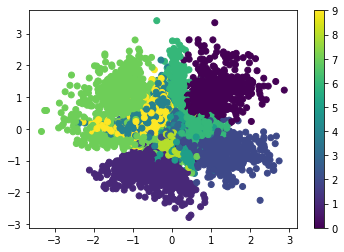

In [19]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
#import matplotlib.pyplot as plt
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
#plt.show() # display a 2D plot of the digit classes in the latent space
encoder_log_var = Model(x,z_log_var)
plt.show()

In [ ]:

plt.title("Histogram de la media 1")
plt.hist(x_test_encoded[:,0])
plt.subplot(322)  

In [0]:
#histograma de la media


  
    
fig.zxes =plt.subplots(1,2, figsize(,))

plt.figure(figsize=(16,10))
plt.title('Histograma de la media')
plt.ylabel('y')
plt.xlabel('x')
(mu, sigma) = norm.fit(list_len_text)
bins=range(min(list_len_text), max(list_len_text) + 1,1)
y = norm.pdf( bins,mu, sigma)
l = plt.plot(bins, y*22901, 'r--', linewidth=2)
plt.hist(list_len_text, bins=range(min(list_len_text), max(list_len_text) + 1,1));

In [0]:
#histograma del logaritmo de la varianza
fig.zxes =plt.subplots(1,2, figsize(,))

plt.figure(figsize=(16,10))
plt.title('Histograma de la media')
plt.ylabel('y')
plt.xlabel('x')
(mu, sigma) = norm.fit(list_len_text)
bins=range(min(list_len_text), max(list_len_text) + 1,1)
y = norm.pdf( bins,mu, sigma)
l = plt.plot(bins, y*22901, 'r--', linewidth=2)
plt.hist(list_len_text, bins=range(min(list_len_text), max(list_len_text) + 1,1));

###  g) Genere nuevos datos artificialmente a través del espacio de las variables latentes. Para esto deberá generar puntos linealmente separados por debajo de la distribución Normal. Comente qué significada cada eje en la imagen ¿Qué sucede más allá en el espacio del 90% confianza de las variables latentes? ¿Qué objetos se generan?

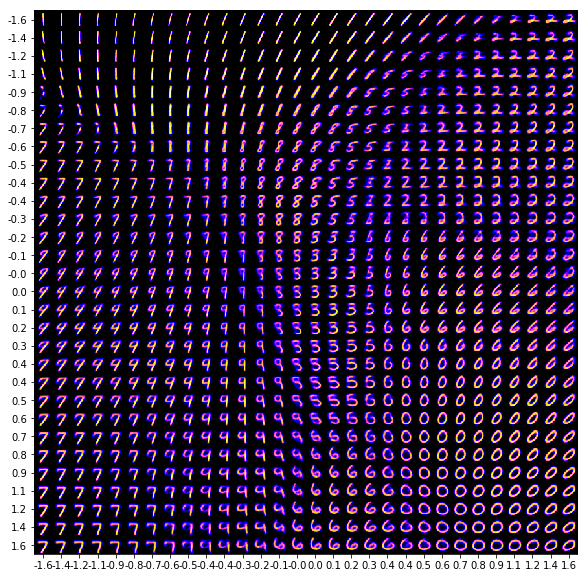

In [20]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) #metodo de la transformada inversa
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
grid = norm.ppf(np.linspace(0.000005, 0.999995, n)) #en los extremos del intervalo de confianza

 Eje x Eje y son las dimensiones de la gaussiana, ya que esta es una gaussiana en 2 dimensiones. Se ven como van variado los valores, lo que estan mas lejos ceros en las esquinas. Si se perturba un poco la variable la latente podría ser un número totalmemte distinto,es decir,hay sensibilidad.

### h) Experimente y comente si mejora o empeora el desempeño de clasificación de la representación encontrada al aumentar la dimensionalidad de las variables latentes $z$, contrarrestándolo con el AE tradicional ($d' = 2,8,16,32 $). Explique.

In [14]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128
latent_dim = 8 # se cambio de 2 a 8
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
encoder = Model(x, z_mean) # build a model to project inputs on the latent space

In [15]:
from keras.layers import Reshape,Conv2DTranspose,Activation
shape_before_flattening = K.int_shape(conv_3)[1:] # we instantiate these layers separately to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon # g = mu + sigma*epsilon
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model
vae_norm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
flatten_3 

In [16]:
from keras import backend as K # Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #closed form
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_norm.add_loss(vae_loss)
vae_norm.summary()
batch_size = 200
epochs =  20
vae_norm.compile(optimizer='rmsprop')
vae_norm.fit(x_train,epochs=epochs, batch_size=batch_size,validation_data=(x_test, None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_8[0][0]                   
__________________________________________________________________________________________________
flatten_3 

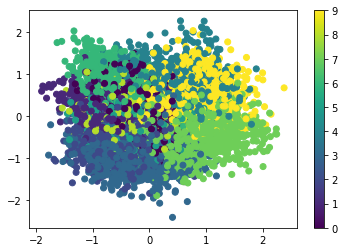

In [17]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
#import matplotlib.pyplot as plt
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
#plt.show() # display a 2D plot of the digit classes in the latent space
encoder_log_var = Model(x,z_log_var)
plt.show()

In [19]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128
latent_dim = 16 # se cambio de 8 a 16
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
encoder = Model(x, z_mean) # build a model to project inputs on the latent space
vae_norm.compile(optimizer='rmsprop')
vae_norm.fit(x_train,epochs=epochs, batch_size=batch_size,validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 40s 672us/step - loss: 20.3041 - val_loss: 20.9857
Epoch 2/20
60000/60000 [==============================] - 39s 653us/step - loss: 20.1699 - val_loss: 20.5211
Epoch 3/20
60000/60000 [==============================] - 39s 654us/step - loss: 20.1176 - val_loss: 21.1911
Epoch 4/20
60000/60000 [==============================] - 40s 666us/step - loss: 20.0144 - val_loss: 20.6973
Epoch 5/20
60000/60000 [==============================] - 40s 660us/step - loss: 19.9273 - val_loss: 20.5835
Epoch 6/20
60000/60000 [==============================] - 39s 658us/step - loss: 19.8509 - val_loss: 20.4556
Epoch 7/20
60000/60000 [==============================] - 40s 660us/step - loss: 19.7816 - val_loss: 20.6061
Epoch 8/20
60000/60000 [==============================] - 40s 659us/step - loss: 19.7207 - val_loss: 20.4339
Epoch 9/20
60000/60000 [==============================] - 39s 657us/step - los

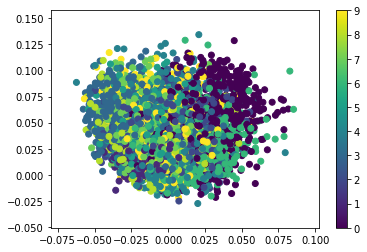

In [20]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
#import matplotlib.pyplot as plt
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
#plt.show() # display a 2D plot of the digit classes in the latent space
encoder_log_var = Model(x,z_log_var)
plt.show()

Claramente al aumentar la dimensión del espacio de las variables latentes, se superponen mas las clases, es decir la probabilidad de que haga buenas predicciones es menor.

## 4.3 Variational Autoencoder categórico

### En esta última sección se explorará el caso en que se cambia el modelamiento sobre la variable latente a una distribuida Multinomial para representar una variable **categórica** que podría entregarnos cierta intuición de capturar las clases del problema de manera no supervisada. Para éste objetivo definiremos el número de variables latentes iguales a la cantidad de clases que sospechamos (en este caso son conocidas y corresponden a 10 dígitos).


 ### a) En primer lugar deberá definir la arquitectura realizando unos cambios leves a la presentada anteriormente. Comente las diferencias sobre los parámetros obtenidos.

### El primer cambio es en la distribución obtenida en el encoder.

In [0]:
... #traditional VAE code here
#latent_dim = 10
#logits_z = Dense(latent_dim,activation='linear')(hidden) #log(p(z))
#encoder = Model(x, logits_z) # build a model to project inputs on the latent space

In [76]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128
latent_dim = 10
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
logits_z = Dense(latent_dim,activation='linear')(hidden) #log(p(z))
z_log_var = Dense(latent_dim,activation='linear')(hidden)
encoder = Model(x, logits_z) # build a model to project inputs on the latent space

###  Luego, con el decoder creado (igual al caso anterior) es necesario cambiar la forma en que se conectan, ya que el muestreo ahora será a través de un truco diferente para variables categoricas (**Gumbel-Softmax[[10]](#refs))**.

In [77]:
from keras.layers import Reshape,Conv2DTranspose,Activation
shape_before_flattening = K.int_shape(conv_3)[1:] # we instantiate these layers separately to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

In [78]:
def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return - K.log( -K.log(U + eps) + eps)
def sampling(logits_z):
    """ Perform a Gumbel-Softmax sampling"""
    tau = K.variable(2/3, name="temperature") 
    z = logits_z + sample_gumbel(K.shape(logits_z)) # logits + gumbel noise
    return keras.activations.softmax( z/tau )    
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))(logits_z)

In [79]:
... #traditional VAE code here
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model
vae_norm.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_18 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               1605760   
_________________________________________________________________
dense_79 (Dense)             (None, 10)                1290      
__________

###  Finalmente la función de pérdida KL cambia ya que se asume un *prior* Multinomial con probabilidad uniforme, $p_{\theta}(z) = \frac{1}{K}$. ¿Qué interpretación se le da a este regularizador?

In [80]:
from keras import backend as K # Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
... #traditional VAE code here
dist =  keras.activations.softmax(logits_z) # =p(z)
dist_neg_entropy = K.sum(dist * K.log(dist + K.epsilon()), axis=1)
kl_disc_loss =  np.log(latent_dim) + dist_neg_entropy #discrete KL-loss
vae_loss = K.mean(reconstruction_loss + kl_disc_loss)
vae_norm.add_loss(vae_loss)
... #traditional VAE code here
vae_norm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_18 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               1605760   
_________________________________________________________________
dense_79 (Dense)             (None, 10)                1290      
__________

### b) Entrene el VAE categórico de la misma manera que realizó con el VAE tradicional en (e) ¿Nota algún cambio en este paso?.


In [82]:
batch_size = 200
epochs =  20
vae_norm.compile(optimizer='rmsprop')
vae_norm.fit(x_train,epochs=epochs, batch_size=batch_size,validation_data=(x_test,None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 45s 754us/step - loss: 41.6937 - val_loss: 40.3826
Epoch 2/20
60000/60000 [==============================] - 41s 681us/step - loss: 39.5667 - val_loss: 38.9919
Epoch 3/20
60000/60000 [==============================] - 39s 658us/step - loss: 37.9169 - val_loss: 37.1956
Epoch 4/20
60000/60000 [==============================] - 39s 652us/step - loss: 36.4621 - val_loss: 36.2600
Epoch 5/20
60000/60000 [==============================] - 38s 641us/step - loss: 35.3450 - val_loss: 34.3845
Epoch 6/20
60000/60000 [==============================] - 39s 643us/step - loss: 34.3559 - val_loss: 34.2707
Epoch 7/20
60000/60000 [==============================] - 40s 670us/step - loss: 33.5223 - val_loss: 32.9417
Epoch 8/20
60000/60000 [==============================] - 38s 641us/step - loss: 32.8798 - val_loss: 32.1091
Epoch 9/20
60000/60000 [==============================] - 39s 644us/step - los

### c) Para ver la efectividad del encoder en lograr capturar las clases es necesario medir una métrica de desempeño, sin embargo, las métricas clásicas como *accuracy* o *f1 score* no corresponderían a este caso debido a que las categoría capturada por el encoder no debería estar en el mismo orden de la clase real, ya que fue un entrenamiento no supervisado ¿Cómo se podría cambiar ésto?. Con esto en mente mida alguna métrica de __[*clustering*](https://scikit-learn.org/stable/modules/clustering.html)__ [[11]](#refs) sobre las categorías inferidas por el VAE. Comente.  
*Recuerde que se predice los logits de la probabilidad*

In [83]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - x.max(axis=-1,keepdims=True) )
    return e_x / e_x.sum(axis=-1, keepdims=True)
p_z_train = softmax(encoder.predict(x_train))
p_z_test = softmax(encoder.predict(x_test))
y_train_pred = p_z_train.argmax(axis=-1)
y_test_pred = p_z_test.argmax(axis=-1)
...#Example
from sklearn.metrics import normalized_mutual_info_score
print(normalized_mutual_info_score(y_train, y_train_pred))
print(normalized_mutual_info_score(y_test, y_test_pred))

0.33849963705327457
0.3612447549501197


C:\Users\Fernanda\Anaconda3\envs\py35\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Normalized Mutual Information (NMI) esta en una escala entere 0 y 1 donde  0 significa que no hay información mutua y 1 es cuando hay correlación perfecta. Recordenemos que la información mutua es una cantidad que mide una relación entre dos
variables aleatorias que se muestrean simultáneamente. En particular, mide cuánta información se comunica en promedio, en una variable aleatoria sobre otra. Esta medida responde la pregunta ¿cuánto me dice una variable aleatoria sobre otra? En este caso las variables generadas en el entrenamiento no supervisado nos dicen cerca de un 35% de la variable original. 

In [87]:
from sklearn.metrics import davies_bouldin_score 
print(davies_bouldin_score(y_train, y_train_pred))
print(davies_bouldin_score(y_test, y_test_pred)) #fallé.


ValueError: Expected 2D array, got 1D array instead:
array=[5 0 4 ... 5 6 8].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [99]:
decoded_imgs = vae_norm.predict(x_test)

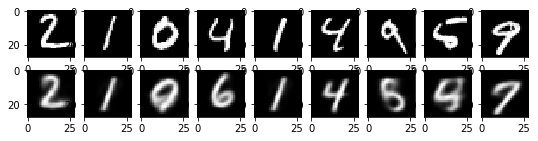

In [100]:
n = 10
plt.figure(figsize=(10, 2))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

###  d) Para entender mejor las categorías inferidas por el VAE genere datos "activando" una categoría y luego realizando un *forward pass* sobre el decoder/generador. Comente cualitativamente.

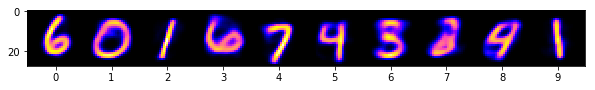

In [88]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 
predictions =np.zeros((img_cols * 1 ,img_cols* latent_dim))
for i in range(latent_dim):
    activate_aux = np.zeros((1,10))
    activate_aux[:,i] = 1 #activate a class
    predictions[:,i * img_cols:(i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(predictions, cmap='gnuplot2')
pos = np.arange(img_cols/2, img_cols*latent_dim, img_cols)
plt.xticks(pos,range(latent_dim))
plt.show()

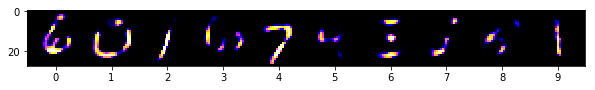

In [96]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 
predictions =np.zeros((img_cols * 1 ,img_cols* latent_dim))
for i in range(latent_dim):
    activate_aux = np.zeros((1,10))
    activate_aux[:,i] = 2 #activate a class
    predictions[:,i * img_cols:(i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(predictions, cmap='gnuplot2')
pos = np.arange(img_cols/2, img_cols*latent_dim, img_cols)
plt.xticks(pos,range(latent_dim))
plt.show()

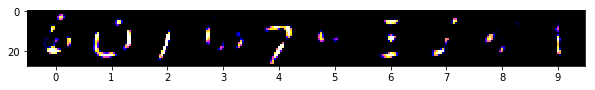

In [90]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 
predictions =np.zeros((img_cols * 1 ,img_cols* latent_dim))
for i in range(latent_dim):
    activate_aux = np.zeros((1,10))
    activate_aux[:,i] = 3 #activate a class
    predictions[:,i * img_cols:(i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(predictions, cmap='gnuplot2')
pos = np.arange(img_cols/2, img_cols*latent_dim, img_cols)
plt.xticks(pos,range(latent_dim))
plt.show()

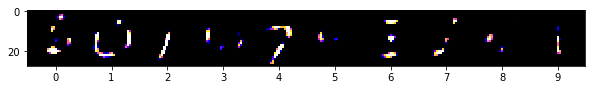

In [91]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 
predictions =np.zeros((img_cols * 1 ,img_cols* latent_dim))
for i in range(latent_dim):
    activate_aux = np.zeros((1,10))
    activate_aux[:,i] = 4 #activate a class
    predictions[:,i * img_cols:(i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(predictions, cmap='gnuplot2')
pos = np.arange(img_cols/2, img_cols*latent_dim, img_cols)
plt.xticks(pos,range(latent_dim))
plt.show()

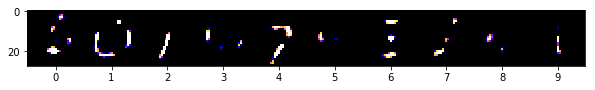

In [92]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 
predictions =np.zeros((img_cols * 1 ,img_cols* latent_dim))
for i in range(latent_dim):
    activate_aux = np.zeros((1,10))
    activate_aux[:,i] = 5 #activate a class
    predictions[:,i * img_cols:(i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(predictions, cmap='gnuplot2')
pos = np.arange(img_cols/2, img_cols*latent_dim, img_cols)
plt.xticks(pos,range(latent_dim))
plt.show()

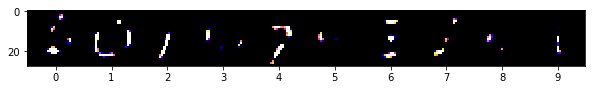

In [93]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 
predictions =np.zeros((img_cols * 1 ,img_cols* latent_dim))
for i in range(latent_dim):
    activate_aux = np.zeros((1,10))
    activate_aux[:,i] = 6 #activate a class
    predictions[:,i * img_cols:(i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(predictions, cmap='gnuplot2')
pos = np.arange(img_cols/2, img_cols*latent_dim, img_cols)
plt.xticks(pos,range(latent_dim))
plt.show()

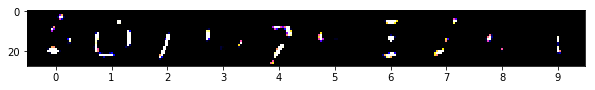

In [94]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 
predictions =np.zeros((img_cols * 1 ,img_cols* latent_dim))
for i in range(latent_dim):
    activate_aux = np.zeros((1,10))
    activate_aux[:,i] = 8 #activate a class
    predictions[:,i * img_cols:(i + 1) * img_cols] = np.squeeze(generator.predict(activate_aux))
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(predictions, cmap='gnuplot2')
pos = np.arange(img_cols/2, img_cols*latent_dim, img_cols)
plt.xticks(pos,range(latent_dim))
plt.show()

Recorriendo las distintas clases, solo para la primera hay imagenes claras, para el resto de las clases se ve cada vez mas difuso.

### e) Genere algunas imágenes aleatorias, comente cualitativamente con lo obtenido con el VAE tradicional ¿Cuál pareciera ser mejor para generar datos? ¿Por qué?

In [127]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 


In [142]:
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
p=0,1
from scipy.stats import bernoulli
grid_x = bernoulli.ppf(p,np.linspace(1, 0,2 , n)) #metodo de la transformada inversa
grid_y = bernoulli.ppf(p,np.linspace(1, 0,2, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
grid = norm.ppf(np.linspace(0.000005, 0.999995, n)) #en los extremos del intervalo de confianza

ValueError: Error when checking input: expected input_32 to have shape (10,) but got array with shape (2,)

In [128]:
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) #metodo de la transformada inversa
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
grid = norm.ppf(np.linspace(0.000005, 0.999995, n)) #en los extremos del intervalo de confianza

ValueError: Error when checking input: expected input_32 to have shape (10,) but got array with shape (2,)

## Referencias
[1] https://es.wikipedia.org/wiki/Ley_de_Zipf    
[2] Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). *Efficient estimation of word representations in vector space*. arXiv preprint arXiv:1301.3781.    
[3] Cho, K., Van Merriënboer, B., Bahdanau, D., & Bengio, Y. (2014). *On the properties of neural machine translation: Encoder-decoder approaches*. arXiv preprint arXiv:1409.1259.  
[4] Pal, N. R., & Pal, S. K. (1993). *A review on image segmentation techniques*. Pattern recognition, 26(9), 1277-1294.  
[5] Badrinarayanan, V., Kendall, A., & Cipolla, R. (2017). *Segnet: A deep convolutional encoder-decoder architecture for image segmentation*. IEEE transactions on pattern analysis and machine intelligence, 39(12), 2481-2495.  
[6] Papineni, K., Roukos, S., Ward, T., & Zhu, W. J. (2002, July). *BLEU: a method for automatic evaluation of machine translation*. In Proceedings of the 40th annual meeting on association for computational linguistics (pp. 311-318). Association for Computational Linguistics.  
[7] Kingma, D. P., & Welling, M. (2013). *Auto-encoding variational bayes*. arXiv preprint arXiv:1312.6114.  
[8] https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence     
[9] Dumoulin, V., & Visin, F. (2016). *A guide to convolution arithmetic for deep learning*. arXiv preprint arXiv:1603.07285.  also: https://github.com/vdumoulin/conv_arithmetic  
[10] Jang, E., Gu, S., & Poole, B. (2016). *Categorical reparameterization with gumbel-softmax*. arXiv preprint arXiv:1611.01144.  
[11] https://en.wikipedia.org/wiki/Cluster_analysis  